# Neural Scattering Fields Demo (TBD)
In this notebook, we use our `misty-lego-bulldozer` scene to demonstrate our multiple-scattering NeRF.\
(Alternatively to this demo, you can also run the model from the command line using `python3 run_nerf.py <path to data> <output path> <environment map path>`)

First, we start by fetching and processing the data (images and poses).

In [1]:
# autoreload imports for dev
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import utils

# get train and test data
train_dict  = utils.load_transforms_json(os.path.join(os.getcwd(), "data", "lego"), "transforms_train.json")
test_dict   = utils.load_transforms_json(os.path.join(os.getcwd(), "data", "lego"), "transforms_test.json")
train_imgs  = utils.get_images_from_folder(os.path.join(os.getcwd(), "data", "lego", "train"))
test_imgs   = utils.get_images_from_folder(os.path.join(os.getcwd(), "data", "lego", "test"))

/Users/stone/dev/coursework/ucsd/wi25/imgsyn_272/multiscatter_nerf/vanilla_backbone


### Camera Pose Visualization
As a sanity check, we can visualize the camera positions and their viewing directions.\
Here, it looks good; all cameras are looking inward towards our scene object.\
We can also visualize our expected test poses, which is a continuous loopy path around the object.

Train poses:


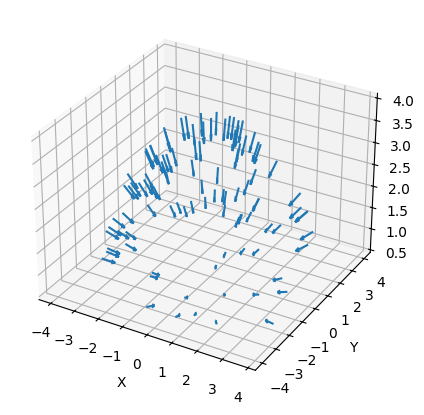

Test poses:


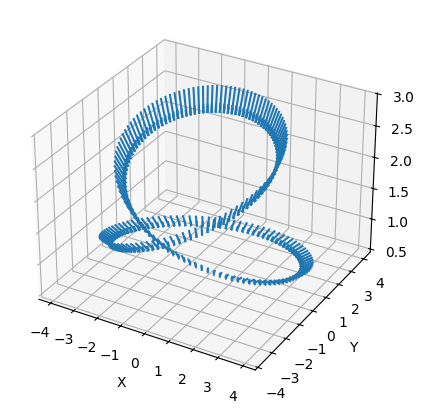

In [24]:
import render

train_poses = train_dict["poses"]
test_poses  = test_dict["poses"]
focal = train_dict["focal"][0]
print("Train poses:")
utils.ray_plot(*render.get_camera_poses(train_poses))
print("Test poses:")
utils.ray_plot(*render.get_camera_poses(test_poses))

## Network
After this, we set up our component modules for our `NeuralScatteringField`, defined in `ms_nerf.py`.

In [ ]:
import tinycudann as tcnn   # only works for T4 GPU in colab/
# construct the network


## Training
Here, we borrow training metadata from the *Neural Relightable Participating Media Rendering* (Zheng et al.) paper.\
At the current time of construction, our model is pretty much the same as theirs, except ours is more constrained in only allowing environment map lighting.\
We train the model for 200K iterations, with a batch of 1200 primary rays each batch.\
We also decay the learning rate from $1\times 10^{-4}\to 1\times 10^{-5}$.

In [ ]:
# call training loop from ms_nerf

## Testing
Here, we render the scene using test poses unseen during training.

In [ ]:
# choose some random test poses and render their views